<h1>PSDV Assignment 3</h1>
<p>Written by
    <ul>
        <li>Kalp Shah 24110152</li>
        <li>Miloni Thakkar 24110204</li>
        <li>Khushi Garg 24110164</li>
    </ul>
</p>

<h2>Importing Libraries, Data Loading and Preprocessing</h2>

In [ ]:
!pip install numpy pandas matplotlib seaborn datetime geopandas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopandas as gpd

In [28]:
# Load datasets
data = pd.read_csv("PSDV_Assignment_3_Data/Data.csv")
state_data = pd.read_csv("PSDV_Assignment_3_Data/State_data.csv")
ncap_funding = pd.read_csv("PSDV_Assignment_3_Data/NCAP_Funding.csv")

# Display basic info
def dataset_info(df, name):
    print(f"Dataset: {name}")
    print(df.info())
    print("-" * 50)

dataset_info(data, "Air Pollution Data")
dataset_info(state_data, "State Data")
dataset_info(ncap_funding, "NCAP Funding Data")

# Convert timestamp column to datetime format with automatic format detection
data["Timestamp"] = pd.to_datetime(data["Timestamp"], format='mixed', dayfirst=True)

# Create year, month, and weekday columns
data["Year"] = data["Timestamp"].dt.year
data["Month"] = data["Timestamp"].dt.month
data["Weekday"] = data["Timestamp"].dt.day_name()

# Convert 'state' column to lowercase in all datasets
data["state"] = data["state"].str.lower()
state_data["State"] = state_data["State"].str.lower()
ncap_funding["State"] = ncap_funding["State"].str.lower()

# Display first few rows of cleaned data
data.head()

Dataset: Air Pollution Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627461 entries, 0 to 1627460
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Timestamp  1627461 non-null  object 
 1   station    1627461 non-null  object 
 2   PM2.5      728348 non-null   float64
 3   PM10       699014 non-null   float64
 4   address    1387431 non-null  object 
 5   city       1563702 non-null  object 
 6   latitude   1563702 non-null  float64
 7   longitude  1563702 non-null  float64
 8   state      1563702 non-null  object 
dtypes: float64(4), object(5)
memory usage: 111.7+ MB
None
--------------------------------------------------
Dataset: State Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       31 non-null     object
 1   Population  31 non-null     int64 
 2   A

,Timestamp,station,PM2.5,PM10,address,city,latitude,longitude,state,Year,Month,Weekday
0,2017-01-01,"32Bungalows, Bhilai - CECB",NaN,NaN,"Bhilai RO Office, 5, 32 Bungalows, Bhilai, Dis...",Bhilai,21.194815,81.314770,chhattisgarh,2017,1,Sunday
1,2017-01-01,"AIIMS, Raipur - CECB",NaN,NaN,"All India Institute Of Medical Science, Gate N...",Raipur,21.258815,81.578979,chhattisgarh,2017,1,Sunday
2,2017-01-01,"Adarsh Nagar, Jaipur - RSPCB",NaN,NaN,"Psychiatric Centre, Janta Colony, Govind Marg,...",Jaipur,26.902909,75.836858,rajasthan,2017,1,Sunday
3,2017-01-01,"Airoli, Navi Mumbai - MPCB",NaN,54.743723,NaN,Navi Mumbai,19.149400,72.998600,maharashtra,2017,1,Sunday
4,2017-01-01,"Airport Area, Indore - IMC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1,Sunday


<h2>Spatial Aggregation</h2>

Which state (consider all stations in that state) has the highest average PM2.5 concentration across all stations and across all years?

In [4]:
# Group by state and calculate the mean PM2.5 concentration
state_avg_pm25 = data.groupby("state")["PM2.5"].mean()

# Identify the state with the highest average PM2.5 concentration
highest_pm25_state = state_avg_pm25.idxmax()
highest_pm25_value = state_avg_pm25[highest_pm25_state]

print(f"State with the highest average PM2.5 concentration: {highest_pm25_state} ({highest_pm25_value:.2f} µg/m³)")

State with the highest average PM2.5 concentration: delhi (104.10 µg/m³)


Which state (consider all stations in that state) had the most days with hazardous PM2.5 levels (above 300 µg/m³) for the year 2023?

In [163]:
# Filter data for the year 2023
data_2023 = data[data["Year"] == 2023]

# Count the number of days with PM2.5 > 300 for each state
hazardous_days_per_state = data_2023[data_2023["PM2.5"] > 300].groupby("state")["Timestamp"].nunique()

# Identify the maximum number of hazardous days
most_hazardous_days = hazardous_days_per_state.max()

# Find all states that have the maximum hazardous days
most_hazardous_states = hazardous_days_per_state[hazardous_days_per_state == most_hazardous_days].index.tolist()

# Display results
print(f"States with the most days of hazardous PM2.5 levels in 2023 ({most_hazardous_days} days):")
print(", ".join(most_hazardous_states))

States with the most days of hazardous PM2.5 levels in 2023 (49 days):
delhi


Which state has the highest variability in PM2.5 levels across its monitoring stations in 2023? (Think how would you measure variability)

Answer: Given that PM2.5 levels often have seasonal spikes and extreme values (like in your graph), IQR is a better choice for detecting variability while reducing the influence of outliers.

In [ ]:
data_2023 = data[data["Year"] == 2023]

# Calculate the IQR of PM2.5 levels for each state
def calculate_iqr(x):
    q3, q1 = np.percentile(x, [75, 25])
    return q3 - q1

state_variability = data_2023.groupby("state")["PM2.5"].agg(calculate_iqr)

# Identify the state with the highest variability
most_variable_state = state_variability.idxmax()
highest_variability = state_variability.max()

print(f"State with the highest variability in PM2.5 levels in 2023: {most_variable_state} (IQR: {highest_variability:.2f})")

State with the highest variability in PM2.5 levels in 2023: puducherry (IQR: 17.49)


Which state has the lowest average PM2.5 levels during the Covid period (The year 2020-2021 both years inclusive)?

In [165]:
# Filter data for the Covid period (2020-2021)
covid_data = data[(data["Year"] >= 2020) & (data["Year"] <= 2021)]

# Compute the average PM2.5 levels for each state
state_avg_pm25_covid = covid_data.groupby("state")["PM2.5"].mean()

# Identify the state with the lowest average PM2.5 concentration
lowest_pm25_state = state_avg_pm25_covid.idxmin()
lowest_pm25_value = state_avg_pm25_covid.min()

print(f"State with the lowest average PM2.5 levels during Covid (2020-2021): {lowest_pm25_state} ({lowest_pm25_value:.2f} µg/m³)")

State with the lowest average PM2.5 levels during Covid (2020-2021): mizoram (14.32 µg/m³)


<h2>Temporal Aggregation</h2>

Report the station that recorded the highest value of PM 2.5 for the month Aug of 2020

In [166]:
# Filter data for August 2020
aug_2020_data = data[(data["Year"] == 2020) & (data["Month"] == 8)]

# Identify the station with the highest PM2.5 value
max_pm25_station = aug_2020_data.loc[aug_2020_data["PM2.5"].idxmax(), ["station", "PM2.5"]]

print(f"Station with the highest PM2.5 in August 2020: {max_pm25_station['station']} ({max_pm25_station['PM2.5']} µg/m³)")

Station with the highest PM2.5 in August 2020: Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB (805.51 µg/m³)


For the year 2018, calculate the average PM2.5 concentration for each season (Seasons being Winter: December-February, Summer: March-May, and Monsoon: June-September) for stations Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB. Identifying the season with the highest pollution.
[Thought Question] Can you suggest some potential factors on why certain seasons are generally more polluted than others?


In [13]:
data_2018 = data[(data["Year"] == 2018) & (data['station'] == 'Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB')]

# Define season mapping
seasons = {
    "Winter": [12, 1, 2],
    "Summer": [3, 4, 5],
    "Monsoon": [6, 7, 8, 9]
}

# Calculate average PM2.5 for each season
seasonal_avg_pm25 = {}
for season, months in seasons.items():
    season_data = data_2018[data_2018["Month"].isin(months)]
    if not season_data.empty:
        seasonal_avg_pm25[season] = season_data["PM2.5"].mean()
    else:
        seasonal_avg_pm25[season] = 0  # Assign 0 if no data for that season

most_polluted_season = max(seasonal_avg_pm25, key=seasonal_avg_pm25.get)

print("Average PM2.5 concentration per season in 2018 for Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB:")
for season, avg_pm25 in seasonal_avg_pm25.items():
    if not np.isnan(avg_pm25):
        print(f"{season}: {avg_pm25:.2f} µg/m³")
    else:
        print(f"{season}: No data available")

print(f"\nSeason with the highest pollution: {most_polluted_season} ({seasonal_avg_pm25[most_polluted_season]:.2f} µg/m³)")

Average PM2.5 concentration per season in 2018 for Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB:
Winter: 67.49 µg/m³
Summer: No data available
Monsoon: 34.43 µg/m³

Season with the highest pollution: Winter (67.49 µg/m³)


Winter (Dec–Feb) – Highest Pollution
Stable Atmosphere & Temperature Inversion: Cold air traps pollutants near the surface, preventing dispersion.
Increased Biomass Burning: More wood, coal, and crop residue burning for heating increases emissions.
Low Wind Speeds: Reduced air circulation allows pollutants to accumulate.
Fog & Smog Formation: High humidity enhances particulate matter accumulation, leading to thick smog.

Summer (Mar–May) – Moderate Pollution
High Wind Speeds: Helps disperse pollutants, reducing concentration.
Increased Photochemical Reactions: High temperatures increase ozone pollution but may reduce PM2.5.
Less Biomass Burning: Decreased heating needs lead to lower emissions.

Monsoon (Jun–Sep) – Lowest Pollution
Heavy Rainfall: Washes out particulate matter from the air.
Strong Winds: Help in pollution dispersion.
Less Human Activity Outdoors: Reduced road dust and industrial emissions due to monsoon slowdowns.

Compare the average PM2.5 levels during weekends and weekdays for the station Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB over the year 2021. Create a plot to show these trends Steps:
Calculate the monthly average PM2.5 for weekdays and weekends separately
X-axis: Months (January to December).
Y-axis: Average PM2.5 levels.
Use two lines: one for the monthly average PM2.5 levels on weekdays and one for weekends.

Used Piecewise Cubic Hermite Interpolation from Scipy to impute Values for August and September as it preserves monotonicity.

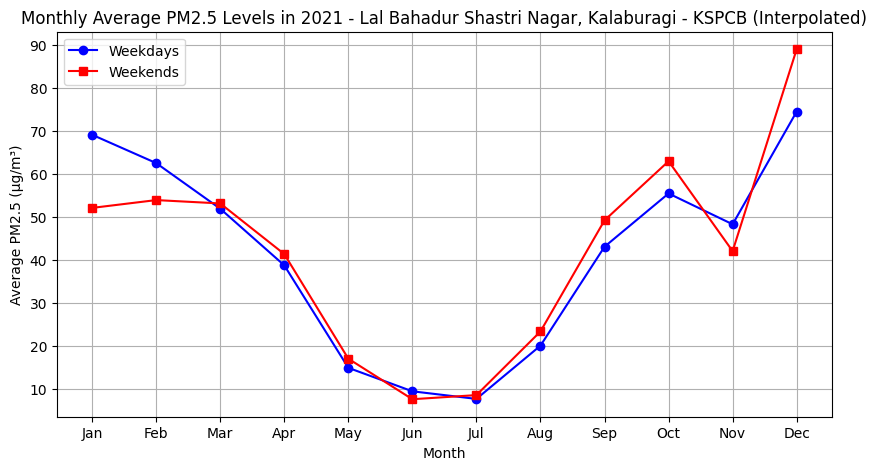

In [17]:
from scipy.interpolate import pchip_interpolate

# Filter data for 2021 and the specified station
station_name = "Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB"
data_2021 = data[(data["Year"] == 2021) & (data["station"] == station_name)].copy()

# Drop NaN values in PM2.5
data_2021 = data_2021.dropna(subset=["PM2.5"])

# Define weekends and weekdays
data_2021["is_weekend"] = data_2021["Weekday"].isin(["Saturday", "Sunday"])

# Group by month and weekend/weekday, then calculate the mean PM2.5
monthly_avg_pm25 = data_2021.groupby(["Month", "is_weekend"])["PM2.5"].mean().unstack()

# Ensure all 12 months exist in the DataFrame
all_months = pd.DataFrame(index=range(1, 13))  # Months 1 to 12
monthly_avg_pm25 = monthly_avg_pm25.reindex(range(1, 13))

for is_weekend in [False, True]:  # False = Weekdays, True = Weekends
    available_months = monthly_avg_pm25.index[~monthly_avg_pm25[is_weekend].isna()]
    available_values = monthly_avg_pm25[is_weekend].dropna().values

    # Use PCHIP for better interpolation
    monthly_avg_pm25[is_weekend] = pchip_interpolate(available_months, available_values, monthly_avg_pm25.index)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_pm25.index, monthly_avg_pm25[False], marker='o', label="Weekdays", linestyle='-', color="blue")
plt.plot(monthly_avg_pm25.index, monthly_avg_pm25[True], marker='s', label="Weekends", linestyle='-', color="red")

plt.xlabel("Month")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title(f"Monthly Average PM2.5 Levels in 2021 - {station_name} (Interpolated)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True)
plt.show()


<h2>Spatio Temporal Aggregation</h2>

For each state, calculate the percentage increase or decrease in PM2.5 levels during monsoon months (June to September) compared to summer months (March to May). Which state has the most difference (increase or decrease) for the year 2022?

In [8]:
# Filter data for the year 2022
data_2022 = data[data["Year"] == 2022]

# Define seasons
summer_months = [3, 4, 5]  # March-May
monsoon_months = [6, 7, 8, 9]  # June-September

# Calculate average PM2.5 levels for each state in summer and monsoon
summer_avg_pm25 = data_2022[data_2022["Month"].isin(summer_months)].groupby("state")["PM2.5"].mean()
monsoon_avg_pm25 = data_2022[data_2022["Month"].isin(monsoon_months)].groupby("state")["PM2.5"].mean()

# Compute absolute percentage change from summer to monsoon
percentage_change = abs((monsoon_avg_pm25 - summer_avg_pm25) / summer_avg_pm25) * 100

# Sort values for better visualization
percentage_change_sorted = percentage_change.sort_values()

# Highlight the state with the most difference
max_diff_state = percentage_change_sorted.idxmax()
max_diff_value = percentage_change_sorted.max()

print(f"State with the highest absolute percentage change in PM2.5 levels (Summer to Monsoon, 2022): {max_diff_state} ({max_diff_value:.2f}%)")

State with the highest absolute percentage change in PM2.5 levels (Summer to Monsoon, 2022): assam (61.18%)


Plot the average PM2.5 levels for Delhi across each season (Winter: December-February, Summer: March-May, Monsoon: June-September) from 2017 to 2023. What seasonal variation, if any, can you observe in pollution levels?

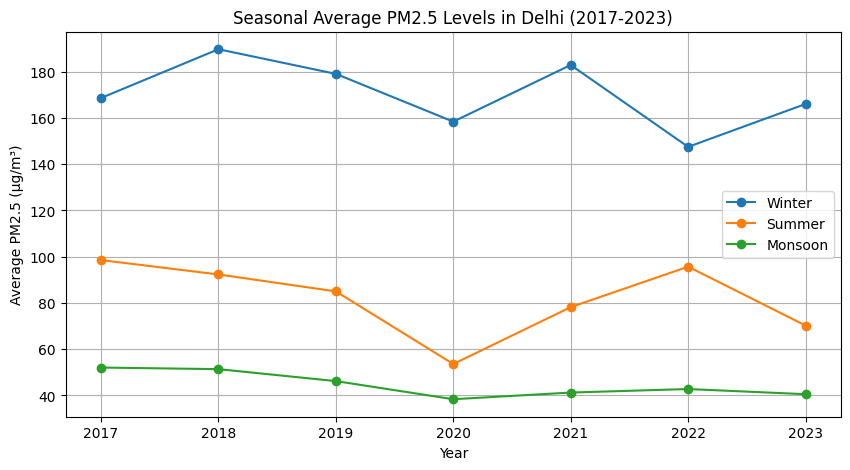

In [170]:
# Filter data for Delhi
delhi_data = data[data["city"] == "Delhi"]

# Define season mapping
seasons = {
    "Winter": [12, 1, 2],
    "Summer": [3, 4, 5],
    "Monsoon": [6, 7, 8, 9]
}

# Compute average PM2.5 per season for each year
seasonal_trends = []
for year in range(2017, 2024):
    yearly_data = delhi_data[delhi_data["Year"] == year]
    for season, months in seasons.items():
        avg_pm25 = yearly_data[yearly_data["Month"].isin(months)]["PM2.5"].mean()
        seasonal_trends.append({"Year": year, "Season": season, "PM2.5": avg_pm25})

# Convert to DataFrame for plotting
seasonal_trends_df = pd.DataFrame(seasonal_trends)

# Pivot data for plotting
pivot_df = seasonal_trends_df.pivot(index="Year", columns="Season", values="PM2.5")

# Plot the trends
plt.figure(figsize=(10, 5))
for season in seasons.keys():
    plt.plot(pivot_df.index, pivot_df[season], marker="o", label=season)

plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("Seasonal Average PM2.5 Levels in Delhi (2017-2023)")
plt.legend()
plt.grid(True)
plt.show()

Plot a time-series graph comparing Delhi’s PM2.5 levels with Mumbai’s from 2015 to 2023. Which city had more fluctuations?

Here, using Standard Deviation is better than Interquartile Range because data is not very skewed and does not have outliers.

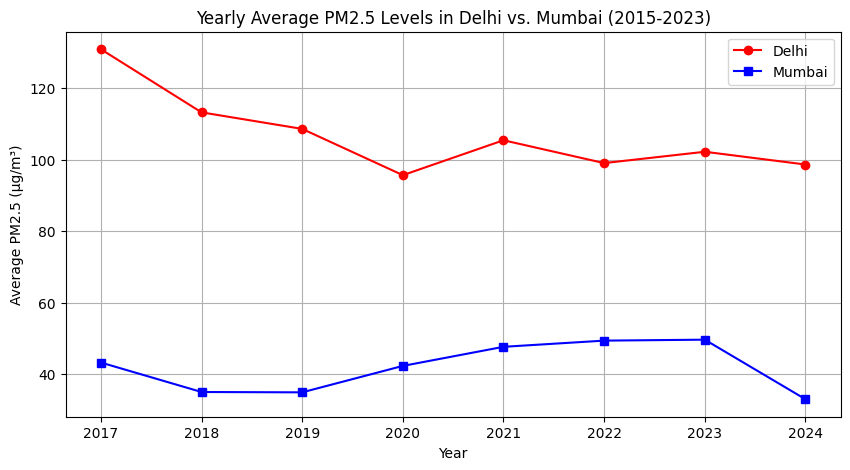

Delhi had more fluctuations in PM2.5 levels (Std Dev: 11.33) than Mumbai (Std Dev: 6.83).


In [ ]:
# Remove 2024

# Filter data for Delhi and Mumbai
cities_of_interest = ["Delhi", "Mumbai"]
city_data = data[data["city"].isin(cities_of_interest)]

# Compute yearly average PM2.5 for both cities
yearly_avg_pm25 = city_data.groupby(["Year", "city"])["PM2.5"].mean().unstack()

# Plot time-series comparison
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg_pm25.index, yearly_avg_pm25["Delhi"], marker="o", linestyle="-", label="Delhi", color="red")
plt.plot(yearly_avg_pm25.index, yearly_avg_pm25["Mumbai"], marker="s", linestyle="-", label="Mumbai", color="blue")

plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("Yearly Average PM2.5 Levels in Delhi vs. Mumbai (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate fluctuation using standard deviation
fluctuation_delhi = yearly_avg_pm25["Delhi"].std()
fluctuation_mumbai = yearly_avg_pm25["Mumbai"].std()

# Determine which city had more fluctuations
if fluctuation_delhi > fluctuation_mumbai:
    print(f"Delhi had more fluctuations in PM2.5 levels (Std Dev: {fluctuation_delhi:.2f}) than Mumbai (Std Dev: {fluctuation_mumbai:.2f}).")
else:
    print(f"Mumbai had more fluctuations in PM2.5 levels (Std Dev: {fluctuation_mumbai:.2f}) than Delhi (Std Dev: {fluctuation_delhi:.2f}).")

<h2>Population Based</h2>

Which state in India has the highest number of monitoring stations relative to its population?

In [172]:
# Count the number of monitoring stations per state
stations_per_state = data.groupby("state")["station"].nunique()

# Merge with state population data from state_data.csv
merged_data = stations_per_state.to_frame().merge(state_data[["State", "Population"]], 
                                                  left_index=True, 
                                                  right_on="State")

# Calculate stations per million people
merged_data["Stations per Million"] = (merged_data["station"] / merged_data["Population"]) * 1e6

# Identify the state with the highest number of stations per million people
highest_station_state = merged_data.loc[merged_data["Stations per Million"].idxmax(), ["State", "Stations per Million"]]

# Display result
print(f"State with the highest number of monitoring stations relative to its population: {highest_station_state['State']} ({highest_station_state['Stations per Million']:.2f} stations per million people)")

State with the highest number of monitoring stations relative to its population: chandigarh (2.84 stations per million people)


Plot a bar chart showing the top 5 most polluted states in terms of per capita PM2.5 exposure in 2023.

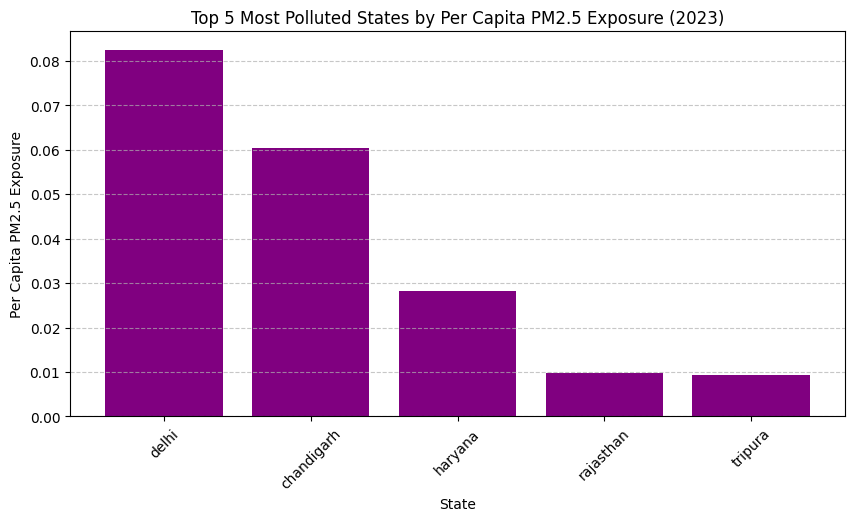

In [9]:
# Filter data for the year 2023
data_2023 = data[data["Year"] == 2023]

# Compute average PM2.5 for each state in 2023
state_avg_pm25 = data_2023.groupby("state")["PM2.5"].sum()

# Merge with state population data
merged_data = state_avg_pm25.to_frame().merge(state_data[["State", "Population"]], 
                                              left_index=True, 
                                              right_on="State")

# Calculate per capita PM2.5 exposure (PM2.5 per person)
merged_data["Per Capita PM2.5"] = merged_data["PM2.5"] / merged_data["Population"]

# Get the top 5 most polluted states based on per capita PM2.5 exposure
top_5_states = merged_data.nlargest(5, "Per Capita PM2.5")

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_5_states["State"], top_5_states["Per Capita PM2.5"], color="purple")
plt.xlabel("State")
plt.ylabel("Per Capita PM2.5 Exposure")
plt.title("Top 5 Most Polluted States by Per Capita PM2.5 Exposure (2023)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Plot the relationship between population density and average PM2.5 concentration for each state. What conclusion can you draw about the correlation between population density and pollution?

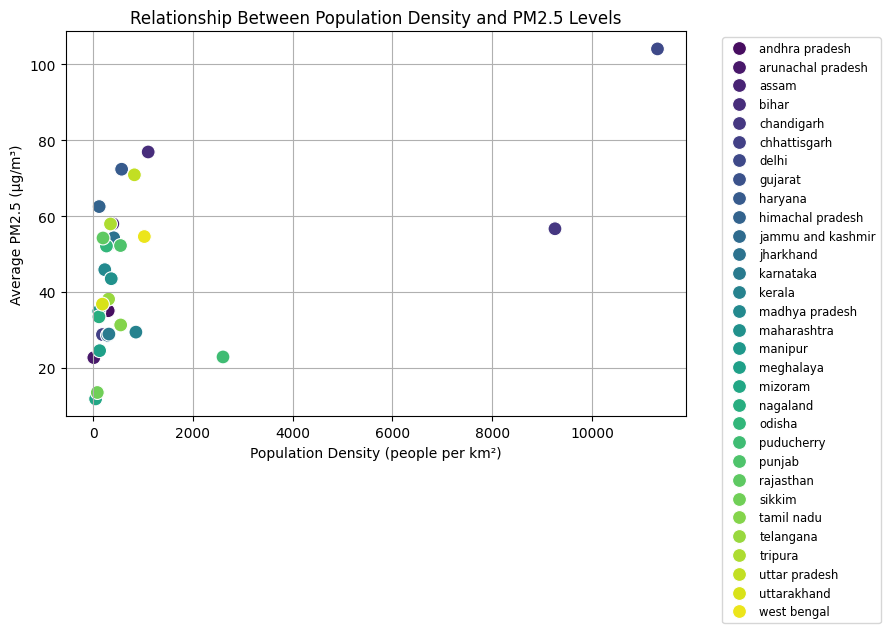

In [174]:
# Compute average PM2.5 for each state
state_avg_pm25 = data.groupby("state")["PM2.5"].mean()

# Merge with state population and area data
merged_data = state_avg_pm25.to_frame().merge(state_data[["State", "Population", "Area (km2)"]], 
                                              left_index=True, 
                                              right_on="State")

# Calculate population density (people per square kilometer)
merged_data["Population Density"] = merged_data["Population"] / merged_data["Area (km2)"]

# Scatter plot for population density vs. average PM2.5
plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_data["Population Density"], y=merged_data["PM2.5"], hue=merged_data["State"], palette="viridis", s=100)

plt.xlabel("Population Density (people per km²)")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("Relationship Between Population Density and PM2.5 Levels")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.grid(True)
plt.show()

We can see that the Population Density of most States is similar but we can establish from the Plot that a Higher Population Density will usually mean a Higher Pollution Level although many states with lower Population Density have higher Pollution Level

<h2>Area Based</h2>

Which state has the highest PM2.5 concentration per square kilometer? Plot the pollution levels for all states relative to their area.
X-axis: States.
Y-axis: PM2.5 concentration per square kilometer.
Use a bar plot where each bar represents a state, and the height shows PM2.5 per sq km.

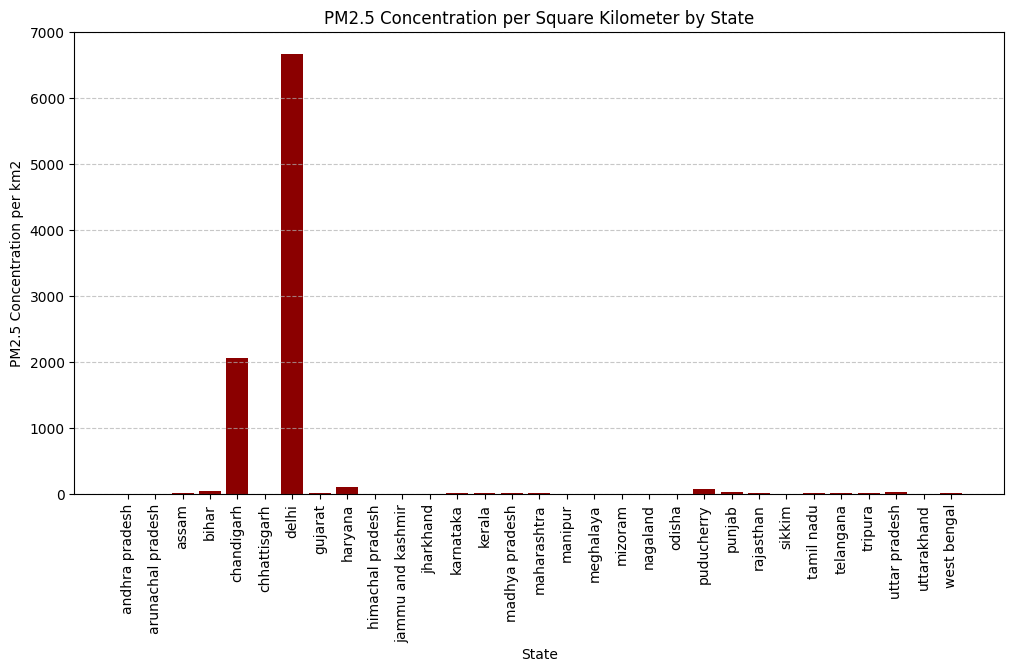

State with the highest PM2.5 concentration per square kilometer: delhi (6673.12 µg/m³ per km²)


In [176]:
# Compute total PM2.5 concentration per state
state_total_pm25 = data.groupby("state")["PM2.5"].sum()

# Merge with state area data
merged_data = state_total_pm25.to_frame().merge(state_data[["State", "Area (km2)"]], 
                                                left_index=True, 
                                                right_on="State")

# Calculate PM2.5 concentration per square kilometer
merged_data["PM2.5 per km2"] = merged_data["PM2.5"] / merged_data["Area (km2)"]

# Identify the state with the highest PM2.5 concentration per km2
highest_pm25_state = merged_data.loc[merged_data["PM2.5 per km2"].idxmax(), ["State", "PM2.5 per km2"]]

# Plot the PM2.5 per km² for all states
plt.figure(figsize=(12, 6))
plt.bar(merged_data["State"], merged_data["PM2.5 per km2"], color="darkred")
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("PM2.5 Concentration per km2")
plt.title("PM2.5 Concentration per Square Kilometer by State")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Display the state with the highest pollution per km²
print(f"State with the highest PM2.5 concentration per square kilometer: {highest_pm25_state['State']} ({highest_pm25_state['PM2.5 per km2']:.2f} µg/m³ per km²)")

Compare the total number of monitoring stations per square kilometer in each state. Identify the state with the highest density of monitoring stations relative to its area. Show a bar plot where each bar represents a state, and the height shows the number of monitoring stations per square kilometer.

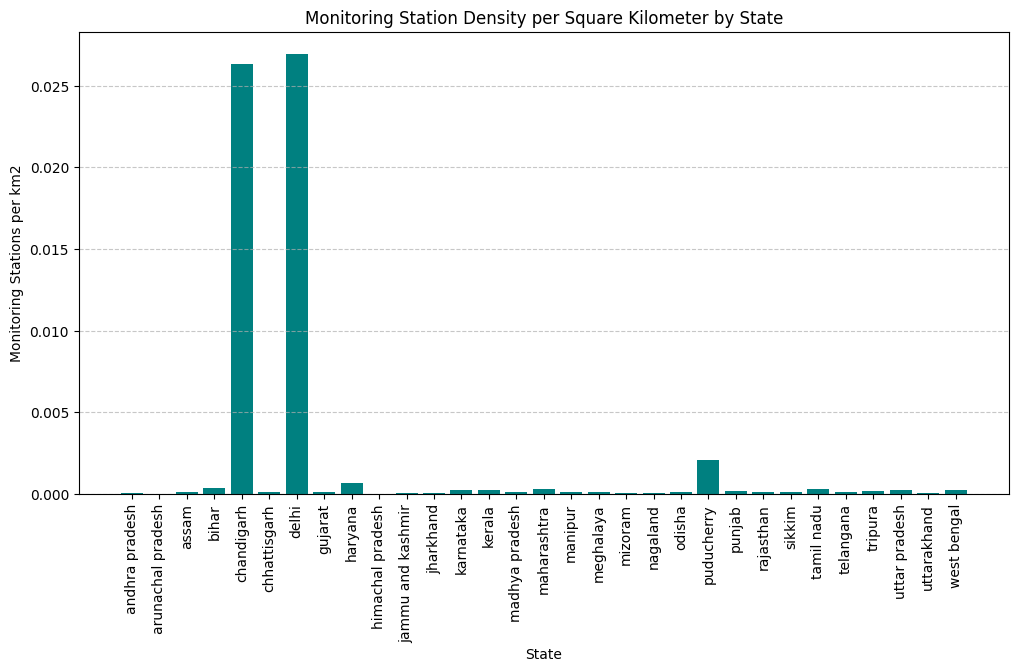

State with the highest monitoring station density: delhi (0.026954 stations per km²)


In [177]:
# Count the number of unique monitoring stations per state
stations_per_state = data.groupby("state")["station"].nunique()

# Merge with state area data
merged_data = stations_per_state.to_frame().merge(state_data[["State", "Area (km2)"]], left_index=True, right_on="State")

# Calculate monitoring station density (stations per km²)
merged_data["Stations per km2"] = merged_data["station"] / merged_data["Area (km2)"]

# Identify the state with the highest monitoring station density
highest_density_state = merged_data.loc[merged_data["Stations per km2"].idxmax(), ["State", "Stations per km2"]]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(merged_data["State"], merged_data["Stations per km2"], color="teal")
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Monitoring Stations per km2")
plt.title("Monitoring Station Density per Square Kilometer by State")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# Display the state with the highest density of monitoring stations
print(f"State with the highest monitoring station density: {highest_density_state['State']} ({highest_density_state['Stations per km2']:.6f} stations per km²)")

Compare the average PM2.5 levels between Maharashtra and Madhya Pradesh over the year 2021. Given that both states have similar area sizes but different population densities, analyze how population density impacts pollution levels in these two states.

In [3]:
# Filter data for Maharashtra and Madhya Pradesh in 2021
states_of_interest = ["maharashtra", "madhya pradesh"]
data_2021 = data[(data["Year"] == 2021) & (data["state"].isin(states_of_interest))]

# Compute average PM2.5 levels for both states
state_avg_pm25 = data_2021.groupby("state")["PM2.5"].mean()

# Merge with population and area data
merged_data = state_avg_pm25.to_frame().merge(state_data[["State", "Population", "Area (km2)"]], 
                                              left_index=True, 
                                              right_on="State")

# Calculate population density (people per square kilometer)
merged_data["Population Density"] = merged_data["Population"] / merged_data["Area (km2)"]

# Display results
print(merged_data[["State", "PM2.5", "Population Density"]].to_string(index=False))

         State     PM2.5  Population Density
madhya pradesh 47.095952          235.608557
   maharashtra 46.440044          365.192023


Maharashtra has highly urbanized and industrial regions like Mumbai, Pune, and Nashik, leading to more vehicular emissions, industrial pollutants, and construction dust.
Madhya Pradesh, despite having large cities like Bhopal and Indore, has more rural and forested regions, which could contribute to better air quality.

<h2>Funding based</h2>

Compare the average PM2.5 levels between states that received NCAP funding and those that did not in 2021.

In [15]:
# Sum the "Amount released during FY 2021-22" at the state level
ncap_funding["Amount released during FY 2021-22"] = pd.to_numeric(
    ncap_funding["Amount released during FY 2021-22"], errors="coerce"
).fillna(0)

state_funding_2021 = ncap_funding.groupby("State")["Amount released during FY 2021-22"].sum().reset_index()

funded_states = state_funding_2021[state_funding_2021["Amount released during FY 2021-22"] > 0]["State"]

data_2021 = data[data["Year"] == 2021]

# Calculate the average PM2.5 levels for funded states
funded_states_data = data_2021[data_2021["state"].isin(funded_states)].groupby("state")["PM2.5"].mean().dropna()
funded_states_pm25 = funded_states_data.mean()

nonfunded_states_data = data_2021[~data_2021["state"].isin(funded_states)].groupby("state")["PM2.5"].mean().dropna()
nonfunded_states_pm25 = nonfunded_states_data.mean()

print(f"Average PM2.5 levels in funded states (2021): {funded_states_pm25:.2f} µg/m³")
print(f"Average PM2.5 levels in non-funded states (2021): {nonfunded_states_pm25:.2f} µg/m³")


Average PM2.5 levels in funded states (2021): 52.62 µg/m³
Average PM2.5 levels in non-funded states (2021): 38.78 µg/m³


Create a time series plot showing PM2.5 levels with an increment in NCAP funding for Assam. Has an increment of the financing led to noticeable improvements in air quality?

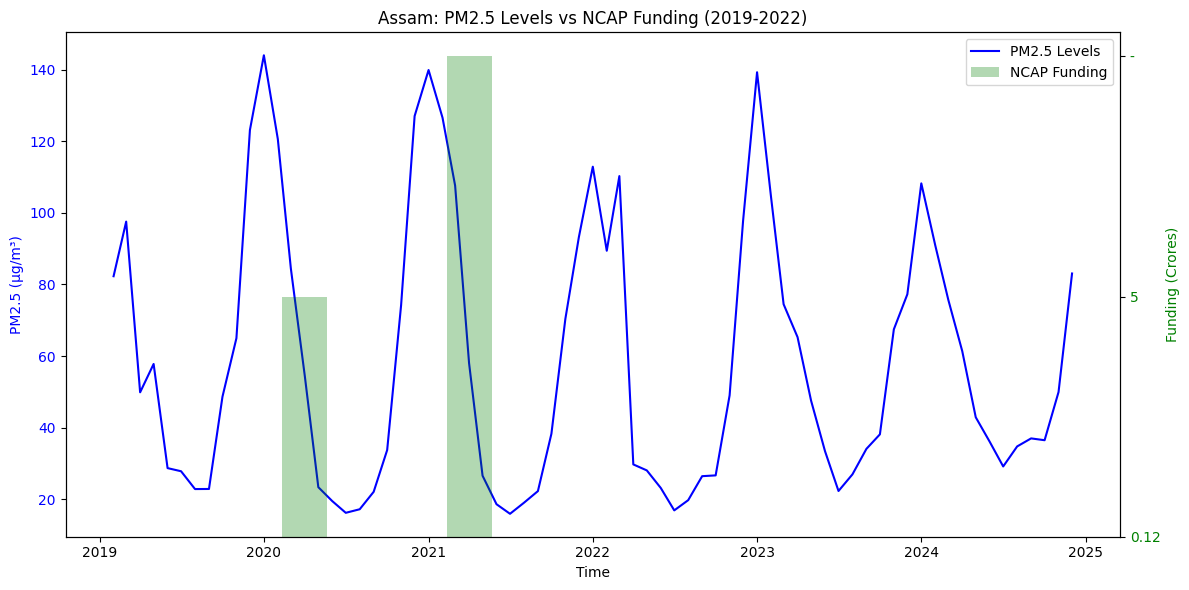

In [181]:
# Filter data for Assam
assam_data = data[data['state'] == 'assam'].copy()

# Calculate monthly average PM2.5 for Assam
monthly_pm25 = assam_data.groupby([assam_data['Timestamp'].dt.to_period('M')])['PM2.5'].mean().reset_index()
monthly_pm25['Timestamp'] = monthly_pm25['Timestamp'].dt.to_timestamp()

# Get Assam's funding data
assam_funding = ncap_funding[ncap_funding['State'] == 'assam'].iloc[0]
funding_years = ['2019-20', '2020-21', '2021-22']
funding_amounts = [
    assam_funding['Amount released during FY 2019-20'],
    assam_funding['Amount released during FY 2020-21'],
    assam_funding['Amount released during FY 2021-22']
]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot PM2.5 levels
line1 = ax1.plot(monthly_pm25['Timestamp'], monthly_pm25['PM2.5'], 
                 color='blue', label='PM2.5 Levels')
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5 (μg/m³)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot funding as vertical bars at specific dates
funding_dates = pd.to_datetime(['2019-04-01', '2020-04-01', '2021-04-01'])
bars = ax2.bar(funding_dates, funding_amounts, width=100, alpha=0.3, 
               color='green', label='NCAP Funding')
ax2.set_ylabel('Funding (Crores)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Assam: PM2.5 Levels vs NCAP Funding (2019-2022)')
plt.tight_layout()
plt.show()

The NCAP Funding for Assam was increased in 2021 but there does not seem to be any immediate change in PM2.5 Levels although it is gradually decreasing from 2023 to 2025. We do not have the data for 2022 to 2025 so we cannot say anything about that time period yet.

Create a scatter plot to showcase the area versus funding received by a state. Mark every state with a different color and show the legend outside the plot.

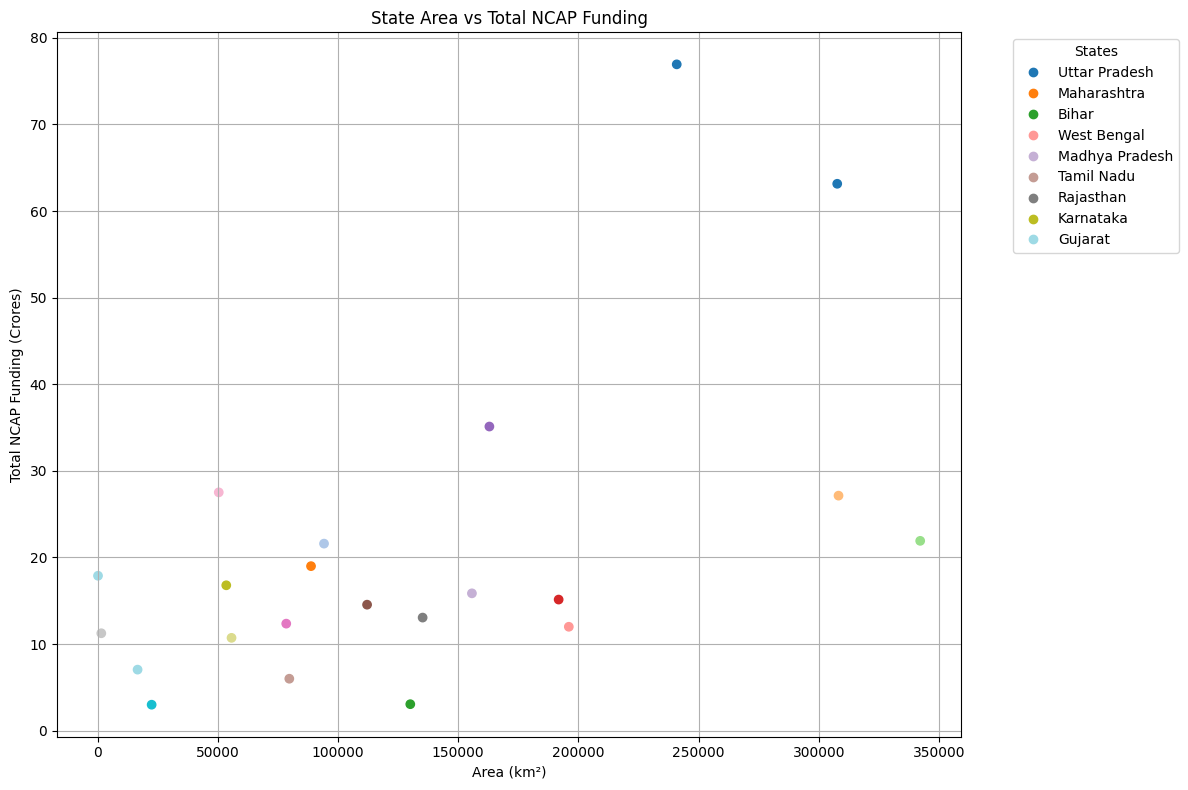

In [182]:
funding_columns = ['Amount released during FY 2019-20', 
                  'Amount released during FY 2020-21', 
                  'Amount released during FY 2021-22']

ncap_funding[funding_columns] = ncap_funding[funding_columns].apply(pd.to_numeric, errors='coerce')

ncap_state_funding = ncap_funding.groupby('State')[funding_columns].sum()
ncap_state_funding = ncap_state_funding.reset_index()

# Calculate total funding for each state
ncap_state_funding['Total_Funding'] = ncap_state_funding[funding_columns].sum(axis=1)

# Merge state data with funding data
merged_data = pd.merge(state_data, ncap_state_funding, 
                      left_on='State', 
                      right_on='State', 
                      how='inner')

plt.figure(figsize=(12, 8))
scatter = plt.scatter(merged_data['Area (km2)'], 
                     merged_data['Total_Funding'],
                     c=np.arange(len(merged_data)), 
                     cmap='tab20')

plt.xlabel('Area (km²)')
plt.ylabel('Total NCAP Funding (Crores)')
plt.title('State Area vs Total NCAP Funding')
plt.legend(scatter.legend_elements()[0], 
          merged_data['State'].str.title(),
          title="States",
          bbox_to_anchor=(1.05, 1),
          loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

<h2>Miscellaneous Questions</h2>

For the most polluted city in 2023 (highest average pollution in 2023), calculate the percentage of days with PM2.5 levels above the hazardous threshold (300 µg/m³)

In [183]:
# Identify the Most Polluted City in 2023
pollution_2023 = data[data["Year"] == 2023]
city_avg_pm25 = pollution_2023.groupby("city")["PM2.5"].mean()
most_polluted_city = city_avg_pm25.idxmax()
highest_avg_pm25 = city_avg_pm25.max()

print(f"Most Polluted City in 2023: {most_polluted_city} with Avg PM2.5 = {highest_avg_pm25:.2f} µg/m³")

# Calculate Percentage of Hazardous Days
city_data_2023 = pollution_2023[pollution_2023["city"] == most_polluted_city]
hazardous_days = (city_data_2023["PM2.5"] > 300).sum()
total_days = city_data_2023["Timestamp"].dt.date.nunique()
hazardous_percentage = (hazardous_days / total_days) * 100

print(f"Percentage of days with PM2.5 > 300 µg/m³ in {most_polluted_city} (2023): {hazardous_percentage:.2f}%")


Most Polluted City in 2023: Darbhanga with Avg PM2.5 = 242.92 µg/m³
Percentage of days with PM2.5 > 300 µg/m³ in Darbhanga (2023): 0.82%


Analyze the PM2.5 levels in Delhi during Diwali (October-November) and New Year compared to regular months over the 3 years (2018-2020). Do you observe any significant pollution spikes during these festivals? If spikes are observed, Can you mark these spikes using arrows?

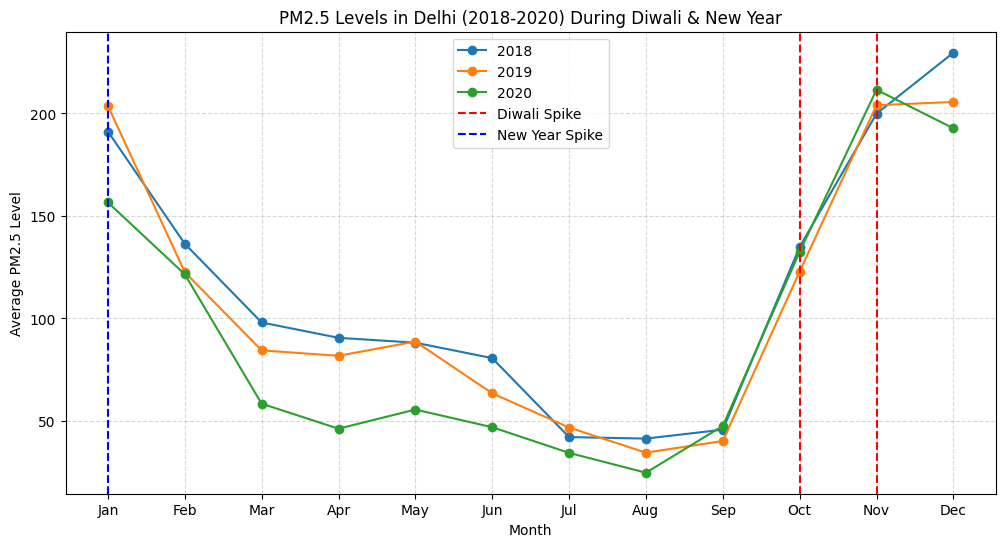

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter Delhi data
delhi_data = data[data["state"] == "delhi"]

# Extract relevant years
delhi_data = delhi_data[(delhi_data["Year"] >= 2018) & (delhi_data["Year"] <= 2020)]

# Group data by year & month to calculate average PM2.5
monthly_avg_pm25 = delhi_data.groupby(["Year", "Month"])["PM2.5"].mean().reset_index()

# Plot PM2.5 trends
plt.figure(figsize=(12, 6))
for year in [2018, 2019, 2020]:
    year_data = monthly_avg_pm25[monthly_avg_pm25["Year"] == year]
    plt.plot(year_data["Month"], year_data["PM2.5"], marker='o', linestyle='-', label=f"{year}")

# Add vertical lines for Diwali (October-November) and New Year (January 1st)
diwali_months = [10, 11]  # October & November
new_year_month = [1]  # January

# Adding vertical lines for Diwali & New Year
for month in diwali_months:
    plt.axvline(x=month, linestyle="--", color="red", label="Diwali Spike" if month == 10 else "")  # Label only for the first instance

for month in new_year_month:
    plt.axvline(x=month, linestyle="--", color="blue", label="New Year Spike")

# Labels & Formatting
plt.xlabel("Month")
plt.ylabel("Average PM2.5 Level")
plt.title("PM2.5 Levels in Delhi (2018-2020) During Diwali & New Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

We observe Signficant Spikes in PM2.5 levels during Festivals such as Diwali and New Year. This is due to People increasing travel with their vehicles and usage of Firecrackers

Identify the state that received the highest NCAP funding in 2020 and determine if its air pollution levels improved significantly by 2023. Use a line graph to compare yearly average PM2.5 trends

State with the highest NCAP funding in 2020-21: assam


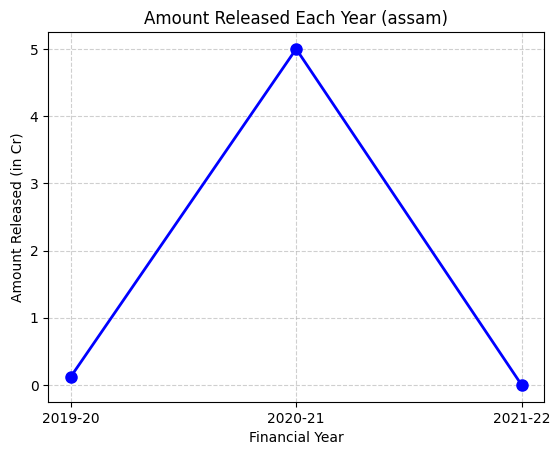

In [26]:
# Find the state with the highest NCAP funding in 2020-21
highest_ncap_funding_2020_state_data = ncap_funding.loc[ncap_funding['Amount released during FY 2020-21'].idxmax()]
highest_ncap_funding_2020_state = highest_ncap_funding_2020_state_data['State']

print(f"State with the highest NCAP funding in 2020-21: {highest_ncap_funding_2020_state}")

# Data from the row
years = ["2019-20", "2020-21", "2021-22"]
amounts = [
    float(highest_ncap_funding_2020_state_data["Amount released during FY 2019-20"]),
    float(highest_ncap_funding_2020_state_data["Amount released during FY 2020-21"]),
    float(highest_ncap_funding_2020_state_data["Amount released during FY 2021-22"])
]

# Plotting the line chart
plt.plot(years, amounts, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel("Financial Year")
plt.ylabel("Amount Released (in Cr)")
plt.title(f"Amount Released Each Year ({highest_ncap_funding_2020_state})")

# Adding grid and showing the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Assam had the highest NCAP Funding in 2020 and the pollution significantly reduced by 2022 but increased back in 2023. This Decrease was probably due to Covid Lockdown and not due to the increase in Funding as a big increase was seen in pollution levels from 2022 to 2023 when the lockdown period ended. Their still was a decrease slightly more than 2 µg/m³. However we cannot correctly assume that this is due to the Funding Period as this may be a result of the Covid Lockdown Period.

Draw the map of India and plot the sensor locations on the map

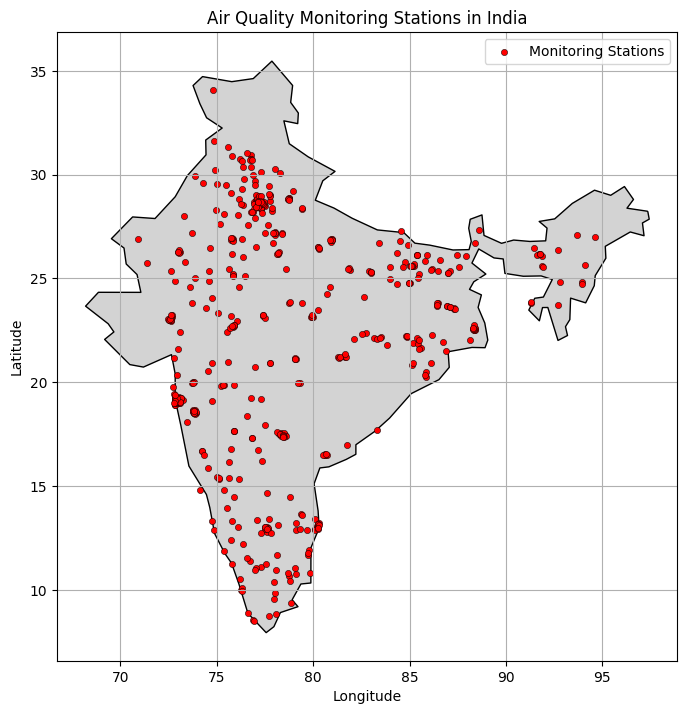

In [186]:
# Load India's map from the extracted Shapefile
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"  # Update this path
world_map = gpd.read_file(shapefile_path)

# Filter only India from the world map
india_map = world_map[world_map["ADMIN"] == "India"]

# Extract monitoring station coordinates (drop duplicates & NaN values)
sensor_locations = data[["latitude", "longitude"]].dropna().drop_duplicates()

# Plot India's map and sensor locations
fig, ax = plt.subplots(figsize=(8, 10))

# Plot India's map
india_map.plot(ax=ax, color="lightgrey", edgecolor="black")

# Overlay air quality monitoring stations
sns.scatterplot(x=sensor_locations["longitude"], y=sensor_locations["latitude"], 
                color="red", edgecolor="black", s=20, label="Monitoring Stations", ax=ax)

# Formatting
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Air Quality Monitoring Stations in India")
plt.legend()
plt.grid(True)

plt.show()

<h2>Tell us Something New</h2>

<p>Cities with NCAP Funding has a similar decreasing curve as non-funded cities for year-by-year PM2.5 Levels so there is a possibility that NCAP Funding is not useful. We cannot be sure about this because NCAP Funded Cities have a significantly higher PM2.5 Level.</p>
<p>We have plotted a Graph below to prove this.</p>

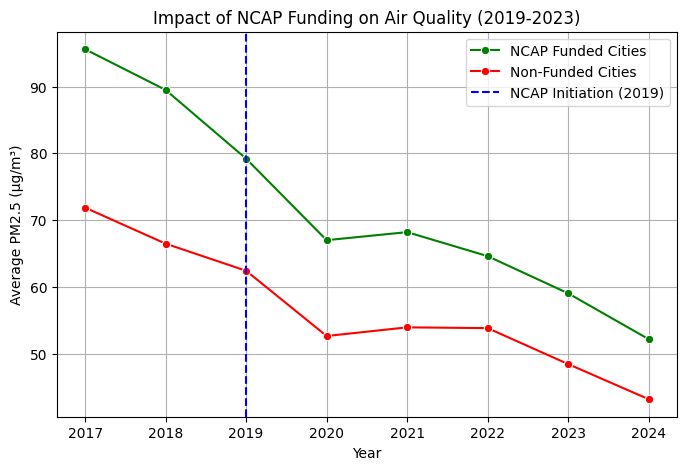

In [196]:
# Step 1: Mark cities that received NCAP funding
funded_cities = ncap_funding["City"].str.lower().unique()
data["NCAP_Funded"] = data["city"].str.lower().isin(funded_cities)

# Step 2: Compute yearly average PM2.5 for funded vs non-funded cities
funding_impact = data.groupby(["Year", "NCAP_Funded"])["PM2.5"].mean().unstack()

# Step 3: Plot the trend
plt.figure(figsize=(8,5))
sns.lineplot(x=funding_impact.index, y=funding_impact[True], label="NCAP Funded Cities", marker="o", color="green")
sns.lineplot(x=funding_impact.index, y=funding_impact[False], label="Non-Funded Cities", marker="o", color="red")

plt.axvline(x=2019, linestyle="--", color="blue", label="NCAP Initiation (2019)")
plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("Impact of NCAP Funding on Air Quality (2019-2023)")
plt.legend()
plt.grid(True)
plt.show()

<p>Cities located near the coast (e.g., Mumbai, Chennai, Kolkata) experience lower PM2.5 levels compared to inland cities (e.g., Delhi, Lucknow, Patna) due to stronger wind dispersal and the absence of winter inversion effects that trap pollutants in landlocked regions. This insight can be useful in planning NCAP Funding as we now know that Inland Cities should be provided with more Funding compared to Coastal Cities.</p>
<p>We have plotted a Graph between some Coastal Cities and Inland Cities to prove this.</p>

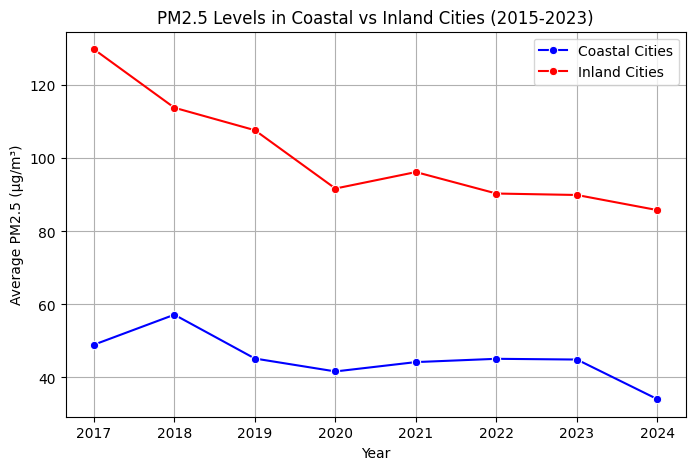

In [199]:
# Define coastal and inland cities
coastal_cities = ["mumbai", "chennai", "kolkata", "visakhapatnam", "kochi"]
inland_cities = ["delhi", "lucknow", "patna", "bhopal", "kanpur"]

# Mark cities as coastal or inland
data["City Type"] = data["city"].str.lower().apply(lambda x: "Coastal" if x in coastal_cities else 
                                                   "Inland" if x in inland_cities else "Other")

# Filter only relevant cities
filtered_data = data[data["City Type"] != "Other"]

# Compute yearly average PM2.5 for both categories
pollution_trend = filtered_data.groupby(["Year", "City Type"])["PM2.5"].mean().unstack()

# Plot the trend
plt.figure(figsize=(8,5))
sns.lineplot(x=pollution_trend.index, y=pollution_trend["Coastal"], label="Coastal Cities", marker="o", color="blue")
sns.lineplot(x=pollution_trend.index, y=pollution_trend["Inland"], label="Inland Cities", marker="o", color="red")

plt.xlabel("Year")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.title("PM2.5 Levels in Coastal vs Inland Cities (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()